In [2]:
include("../../BFFPSV18.jl")

┌ Info: Precompiling Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1273


add_time! (generic function with 2 methods)

In [1]:
] add BenchmarkTools

  Updating registry at `C:\Users\marce\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\marce\.julia\environments\v1.3\Project.toml`
  [6e4b80f9] + BenchmarkTools v0.4.3
  Updating `C:\Users\marce\.julia\environments\v1.3\Manifest.toml`
 [no changes]


## Model

In [3]:
# ======================================
# Model: Motor (8 variables, 2 inputs)
# ======================================

using SparseArrays

# =====================
# Problem specification
# =====================
I = [1, 2, 2, 3, 3, 3, 3, 4, 5, 6, 6, 7, 7, 7, 7, 8]
J = [2, 3, 2, 1, 2, 3, 4, 1, 6, 7, 6, 5, 6, 7, 8, 5]
vals = [1, 8487.2, -1.0865, -2592.1, -21.119, -698.91, -141399.0, 1.0, 1.0,
       8487.2, -1.0865, -2592.1, -21.119, -698.91, -141399.0, 1.0]
A = sparse(I, J, vals)

# initial set
X0 = Hyperrectangle([0.00225, 0.0, 0.0, 0.0, 0.00125, 0.0, 0.0, 0.0],
                    [0.00025, 0.0, 0.0, 0.0, 0.00025, 0.0, 0.0, 0.0])

# input set
B = sparse([4, 8], [1, 2], [-1.0, -1.0])
U = Hyperrectangle([0.23, 0.3], [0.07, 0.1])

# instantiate continuous LTI system
S = ConstrainedLinearControlContinuousSystem(A, B, nothing, U)
P = InitialValueProblem(S, X0);

## Reach

In [4]:
# two partition strategies
partition_2D = [(2*i-1:2*i) for i in 1:4] # 2D blocks
partition_1D = [[i] for i in 1:8]; # 1D blocks

### Solution with upstream implementation

In [5]:
opts = Options(:T => 20.0, :plot_vars => [0, 5])
opts_algo = Options(:δ => 0.001, :vars => [5], :partition => partition_1D)

Options(Dict{Symbol,Any}(:vars => [5],:partition => Array{Int64,1}[[1], [2], [3], [4], [5], [6], [7], [8]],:δ => 0.001))

In [6]:
sol = solve(P, opts, op=BFFPSV18(opts_algo));

In [7]:
using BenchmarkTools

In [8]:
@btime solve($P, $opts, op=BFFPSV18($opts_algo));

  924.657 ms (2761209 allocations: 138.30 MiB)


In [17]:
using Plots

In [37]:
# uncomment to plot.. Jubpyter notebook gets slowed down with large figures, and this contains 20k sets
#plot([set(sol.Xk[i]) for i in eachindex(sol.Xk)], xlab="t", ylab="x5", lw=0.0, alpha=.2, color=:lightblue)

In [66]:
add_time!(sol.Xk)

In [67]:
h = maximum(ρ([0.0, 1.0], set(sol.Xk[i])) for i in 1:100)

0.44086955401842315

In [131]:
# All variables

opts = Options(:T => 20.0, :plot_vars => [0, 5])
opts_algo = Options(:δ => 0.001, :vars => [1, 2, 3, 4, 5, 6,7, 8], :partition => partition_1D)

sol = solve(P, opts, op=BFFPSV18(opts_algo));

@btime solve($P, $opts, op=BFFPSV18($opts_algo));

Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:04
Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:03
Computing successors 100%|██████████████████████████████| Time: 0:00:03


  4.071 s (20737022 allocations: 1.04 GiB)


### Solution with local implementation

In [9]:
S = ConstrainedLinearControlContinuousSystem(MMatrix{8, 8, Float64}(A), B, nothing, U)
#S = ConstrainedLinearControlContinuousSystem(A, B, nothing, U)

P = InitialValueProblem(S, X0);

In [10]:
# UNIFORM 1D partition
opts = Options(:T => 20.0,
               :δ => 0.001,
               :N => 20_000,  # el N se puede sacar de T y de delta
               :vars=>[5],
               :partition => partition_1D,
               :set_type => Interval{Float64, IA.Interval{Float64}},
               :row_blocks => [[5]],
               :column_blocks => partition_1D,
               :num_type => Float64,
               :block_indices => [5]);
# varias de las opciones anteriores se pueden deducir de otras!

In [11]:
sol = solve_BFFPSV18(P, opts);

In [12]:
@btime solve_BFFPSV18($P, $opts);
#

# some results:
# homogeneous case (no input)  85.737 ms (100333 allocations: 4.30 MiB)
#
# with input:
#  69.154 ms (340536 allocations: 22.32 MiB)

#   58.197 ms (320475 allocations: 21.40 MiB)

  57.402 ms (320496 allocations: 21.40 MiB)


In [41]:
set(sol[1])

CartesianProductArray{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}[Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.000966973, 0.00152523])])

In [42]:
# add time as the first variable
add_time!(sol)

In [43]:
set(sol[1])

CartesianProductArray{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}[Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0.00100001]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.000966973, 0.00152523])])

In [44]:
# slow .. there are 20k sets to plot
plot([set(sol[i]) for i in eachindex(sol)], xlab="t", ylab="x5")

In [51]:
h = maximum(ρ([0.0, 1.0], set(sol[i])) for i in 1:100)

0.44086955401841793

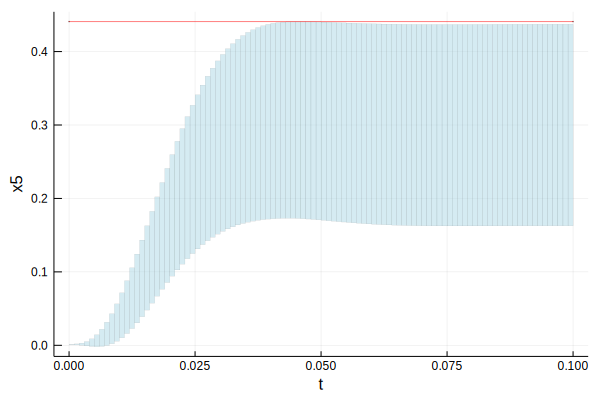

In [62]:
# "rise" time
plot([set(sol[i]) for i in 1:100], xlab="t", ylab="x5", color=:lightblue, lw=0.1)
plot!(LineSegment([0.0, h], [0.1, h]), color=:red, marker=0, lw=1.)

In [93]:
# UNIFORM 2D partition
opts = Options(:T => 20.0,
               :δ => 0.001,
               :N => 20_000,  # el N se puede sacar de T y de delta
               :vars=>[5],
               :partition => partition_2D,
               :set_type => Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}},
               :row_blocks => [[5, 6]],
               :column_blocks => partition_2D,
               :num_type => Float64,
               :block_indices => [3]); # indices of blocks that need to be computed
# varias de las opciones anteriores se pueden deducir de otras!

In [94]:
partition_2D

4-element Array{UnitRange{Int64},1}:
 1:2
 3:4
 5:6
 7:8

In [95]:
sol = solve_BFFPSV18(P, opts);

In [74]:
@btime solve_BFFPSV18($P, $opts);
# some results:
# 

  210.287 ms (1459871 allocations: 97.68 MiB)


In [96]:
add_time!(sol) # since we have used 2D hyperrectangles, after adding time the set is 3D so we project below

In [104]:
# we can verify that the result is the same as with interval
h = maximum(ρ([0.0, 1.0], LazySets.project(set(sol[i]), 1:2, LazySets.LinearMap)) for i in 1:100)

0.440869554018417

In [142]:
# All variables

S = ConstrainedLinearControlContinuousSystem(A, B, nothing, U)
#S = ConstrainedLinearControlContinuousSystem(A, B, nothing, U)
P = InitialValueProblem(S, X0);

# UNIFORM 1D partition
opts = Options(:T => 20.0,
               :δ => 0.001,
               :N => 20_000,  # el N se puede sacar de T y de delta
               :vars=>[1, 2, 3, 4, 5, 6, 8],
               :partition => partition_1D,
               :set_type => Interval{Float64, IA.Interval{Float64}},
               :row_blocks => partition_1D,
               :column_blocks => partition_1D,
               :num_type => Float64,
               :block_indices => [1, 2, 3, 4, 5, 6, 7, 8]);


sol = solve_BFFPSV18(P, opts);
@btime solve_BFFPSV18($P, $opts);

  909.487 ms (2160606 allocations: 140.13 MiB)


In [135]:
dim(set(sol[10]))

8

# Results

```julia
julia> versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
```


## Reach algorithm

### One variable


|Algorithm|Partition|Set type|Runtime (ms) and Allocations|Speedup|
|------|-----------|------|------|------|
|upstream|2d uni|hyperrectangle|967.187 ms (2000545 allocations: 106.88 MiB)|-|
|upstream|1d uni|interval|879.466 ms (2680566 allocations: 137.07 MiB)|1x|
|local|2d uni|hyperrectangle|210.287 ms (1459871 allocations: 97.68 MiB)|4.6x|
|local|1d uni|interval| 69.154 ms (340536 allocations: 22.32 MiB)|13x|
|local, w/sarray|1d uni| interval|58.197 ms (320475 allocations: 21.40 MiB)|16x|

The speedup is measured wrt the fastest upstream method, in this case interval.

In [117]:
1.9 / 58.2e-3

32.64604810996563

### All variables

|Algorithm|Partition|Set type|Runtime (ms) and Allocations|Speedup|
|------|-----------|------|------|------|
|upstream|2d uni|hyperrectangle||-|
|upstream|1d uni|interval| 4.071 s (20737022 allocations: 1.04 GiB)|1x|
|local|2d uni|hyperrectangle||x|
|local|1d uni|interval| |x|
|local, w/sarray|1d uni| interval|764.457 ms (2000552 allocations: 147.44 MiB)| 5.3x|

In [143]:
4.071 / 764e-3

5.3285340314136125

## Check algorithm

## Check

In [ ]:
# property: x1 < 0.35 || x5 < 0.45
property = Disjunction([SafeStatesProperty(HalfSpace([1.; zeros(7)], 0.35)),
                        SafeStatesProperty(HalfSpace([zeros(4); 1.; zeros(3)], 0.45))])

In [ ]:
opts = Options(:plot_vars => [0, 5], :property => property)
opts_algo = Options(:vars => [5], :partition => partition_2D)

## Error bounds